# StackOverflow Query Workshop
<br/>

---

# Natural Language Processing

A variety of techniques fall under the heading of Natural Language Processing.  We're going to be concentrating on written, English language textual analysis.

The data we're collecting comes from the post.Body field in the stackoverflow API.  Importantly, this isn't natural text in the sense that it contains light HTML markup.  We'll use some quick regexes and a general cleaner package to help remove the most non-human machine tags of the HTML to operate as best we can on only the human-level explanations of code given.

After that, we'll parse through several months of our data and apply a very simple sentiment analysis to see how the text scores over time.  In addition to looking over time, we'll see how the R data for sentiment compares to other languages, and what of significance that has.

The analysis package we're using comes from the Stanford Core NLP project: https://github.com/stanfordnlp/CoreNLP.  This is 1-2 generations back of NLP, prior to the deep learning revolution and the use of word embeddings.  However, as a metric, it's easy to setup and doesn't require an explicit traning step.

Then, we'll compare this to one of the first major releases of the deep learning era, in the form of the Facebook-trained FastText library.

### First, let's construct the data set.



Using this query:

```SQL 
SELECT 
p.ViewCount, a.Id as AskerId, a.Reputation as AskerReputation, a.DisplayName as QuestionAsker, p.CreationDate as DateAsked, p.Id as PostId, p.Title, p.AnswerCount, p.Score as QuestionScore, t.TagName, b.Id as AnswererId, b.Reputation as AnswererReputation, b.DisplayName as Answerer, answer.CreationDate as DateAnswered, answer.Score as AnswerScore,
case 
  WHEN ((p.AcceptedAnswerId = answer.Id)) THEN 'selected answer'
  ELSE 'attempted answer'
END as answertype,
answer.Body
FROM Users a, Posts p, Users b, Posts answer, PostTags pt, Tags t
WHERE p.OwnerUserId = a.Id      -- or accountId?
  AND t.TagName in ('r')
  AND answer.OwnerUserId = b.Id -- or accountId
  AND p.PostTypeId = 1          -- question
  AND answer.PostTypeId = 2     -- answer
  AND Pt.PostId = p.id
  AND t.Id = pt.TagId
  AND answer.parentid = p.Id
  AND p.CreationDate >= '2018-01-01'
  AND p.CreationDate < '2019-01-01'
ORDER by p.CreationDate asc, answertype desc;

-- For answered questions
-- give me data about
--   the question
--   the question asker
--   the selected answer
--   the non-selected answers
--   the basic ids, scores of each, and their authors
--   AND THE FULL TEXT
-- for questions tagged with the language R
-- ordered by creation date

```

From: https://data.stackexchange.com/stackoverflow/query/1093476/questions-answers-usernames-dates-and-full-text-for-r-tagged-questions


## Data munging

You can query through and download each of those, saving to a /data/nlp folder like so:




In [2]:
## files <- list.files("./data/nlp/", full.names=T, pattern="Query-")
##  df <- data.frame(do.call(rbind,
##                          lapply(files,
##                                 function(x) read.csv(x,
##                                                      stringsAsFactors = FALSE)
##                                 )
##                          )
##                  )
## df <- df[!duplicated(df), ]

# write.csv(df, "./data/nlp/master-query.csv")

Or just use the file I've created running the above:

In [1]:
df <- read.csv("./data/nlp/master-query.csv", stringsAsFactors=FALSE)
dim(df)
print(colnames(df))

[1] 156581     18

 [1] "X"                  "ViewCount"          "AskerId"           
 [4] "AskerReputation"    "QuestionAsker"      "DateAsked"         
 [7] "PostId"             "Title"              "AnswerCount"       
[10] "QuestionScore"      "TagName"            "AnswererId"        
[13] "AnswererReputation" "Answerer"           "DateAnswered"      
[16] "AnswerScore"        "answertype"         "Body"              


In [5]:
require("rJava")
require("cleanNLP")
require("textclean")

cnlp_download_corenlp(type=c("base", "english"), output_loc="./nlp/Stanford/stanford-corenlp-full-2018-10-05")
# If that doesn't work, you can download manually:
# wget https://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip https://nlp.stanford.edu/software/stanford-english-corenlp-2018-10-05-models.jar
# unzip stanford-corenlp-full-2018-10-05.zip
# unzip stanford-english*
# mv stanford-corenlp-full-2018-10-05 ./nlp/Stanford/stanford-corenlp-full-2018-10-05
# mv stanford-english-corenlp-2018-10-05-models.jar stanford-corenlp-full-2018-10-05


# DEMONSTRATION
cnlp_init_corenlp(anno_level = 1L, lib_location = "./nlp/Stanford/stanford-corenlp-full-2018-10-05", verbose=TRUE)

# Test Good
anno <- cnlp_annotate("This is wonderful, pleasant set of words!", as_strings = TRUE, backend = "coreNLP")
cnlp_get_sentence(anno)

# Test Bad
anno <- cnlp_annotate("This is horrible, negative, gross, bad!", as_strings = TRUE, backend = "coreNLP")
cnlp_get_sentence(anno)

# Test Both
anno <- cnlp_annotate(c("This is wonderful, pleasant set of words!", "This is horrible, negative, gross, bad!"), as_strings = TRUE, backend = "coreNLP")
cnlp_get_sentence(anno)


Loading NLP pipeline.
(This may take several minutes.Please be patient.)


id,sid,sentiment
<chr>,<int>,<int>
doc1,1,4


id,sid,sentiment
<chr>,<int>,<int>
doc1,1,0


id,sid,sentiment
<chr>,<int>,<int>
doc1,1,4
doc2,1,0


In [33]:
# naive progress bar, though pb <- txtProgressBar(min=0,max=N) is better...
counter <<- 0

# define a cleaning function
cleaner <- function(x, n=500) {
    # first... 
    a <- gsub("<code>.*?</code>", " ", x) # remove <code>.*</code> 
    b <- gsub("<pre>.*?</pre>", " ", a)   # and    <pre>.*</pre>
    c <- gsub("\\s+", " ", b)             # and consecutive spaces
    # then remove any additional markup
    clean <- trimws(replace_html(c))
    # then substring the remainder
    body <- substr(clean,1,n+1)
    return(body)
    }


# Define a sentiment function
sentiment_per_body <- function(x, n=500, verbose=FALSE) {
    counter <<- counter + 1
    print(counter)
    body <- cleaner(x, n)
    if(verbose) { print(body) }
    # now compute sentiment
    anno <- cnlp_annotate(body, as_strings = TRUE, backend = "coreNLP")
    df <- data.frame(cnlp_get_sentence(anno))
    if(verbose) { print(df) }
    return(mean(df$sentiment))
}

## Spot checks

Let's see how this does


For scores, 0 is the most negative and 4 is the most postive.

```R
corpus <- head(df$Body,10)

> sentiment_per_body(corpus[2])
[1] "I, uh, \"just happened to have\" a copy of this font and did the dance and got your error. 
But, upon further inspection:   it seems the PDF device wants this name.   
While R has a host of awesomeness, the way it deals with fonts is about as nuanced and friendly 
and usable as a lizard crow (#atla).     UPDATE    Complete example (without the broken creation 
code and referencing vs and actually ing vs or after modifying the ggplot gtable:   That ^^ 
part makes the following PDF (exported from Preview as a PNG):         
That ^^ part makes the following PDF (exported from Preview as a PNG):         
Here's a screen grab from RStudio (with bits of RStudio UI included to show it's in an 
RStudio graphics device):         It's sad that we have to do this (change naming conventions 
for the font so various bits of R presentation code can pick the right one) but that's the 
current state of fonts in R.   I generate content for research reports for my company and separate 
theme code for screen (during d"
    id sid sentiment
1 doc1   1         1
2 doc1   2         1
3 doc1   3         1
4 doc1   4         0
[1] 0.75

> sentiment_per_body(dirty_corpus[3])
> [1] "Your R interpreter is attempting to run Ghostscript 
from \"C:\\program files\\gs\\gs9.09\\bin\", whereas your Windows command line is executing 
Ghostscript 9.18.   Assuming that you installed a newer version of Ghostscript (using the installer) 
this means that Ghostscript will be installed in \"C:\\program files\\gs\\gs9.18\\bin\".   
You should check to see if you have Ghostscript 9.09 installed and. if not, then you will 
need to update your R configuration to use the correct directory for GS 9.18."
    id sid sentiment
1 doc1   1         1
2 doc1   2         1
3 doc1   3         1
4 doc1   4         1
[1] 1

> sentiment_per_body(dirty_corpus[5])
[1] "In addition to the answers provided in the link here is a / solution:"
    id sid sentiment
1 doc1   1         3
[1] 3

```

Per licensing guidelines: https://archive.org/details/stackexchange

These are available:
- https://stackoverflow.com/a/41413654/1052117
- https://stackoverflow.com/a/41524670/1052117
- https://stackoverflow.com/a/41414757/1052117


In [ ]:
# Chunk the data frame into months so we can come back to our work.
s <- split(df, format(as.Date(df$DateAnswered), "%Y-%m"))

# This takes awhile.  I would not recommend running on a laptop.
for(i in seq_along(s)) {
    print(names(s)[i])
    counter <<- 0  
    filename <- paste0("sentiment-", names(s)[i], ".csv")
    if(file.exists(filename)) {
        print("File exists, passing.")
        next
    }
    new_df <- s[[i]]
    corpus <- new_df$Body
    print(paste0("Length is: ", length(corpus)))
    sentiment <- do.call(rbind, lapply(corpus, sentiment_per_body)) # setTxtProgressBar(pb, i)
    new_df$sentiment  <- sentiment
    write.csv(new_df, filename)
}

## Let's see sentiment over time

Here's how we'd set it up for January

In [22]:
require(xts) # time series time
options(repr.plot.width=8, repr.plot.height=4)

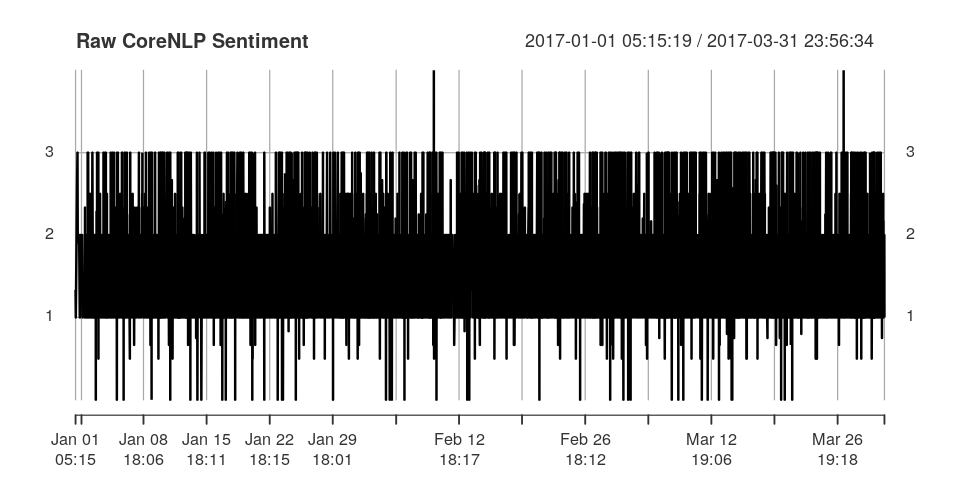

In [28]:
# Get the series

files <- list.files("./", pattern="sentiment-*",full.names=T)

dfs <- data.frame(do.call(rbind,
                         lapply(files[-1],
                                function(x) read.csv(x,
                                                     stringsAsFactors = FALSE)
                                )
                         )
                 )

ts <- as.xts(dfs$sentiment, order.by=as.POSIXct(dfs$DateAnswered))

# Untransformed, uninformative:
plot(ts, main="Raw CoreNLP Sentiment")

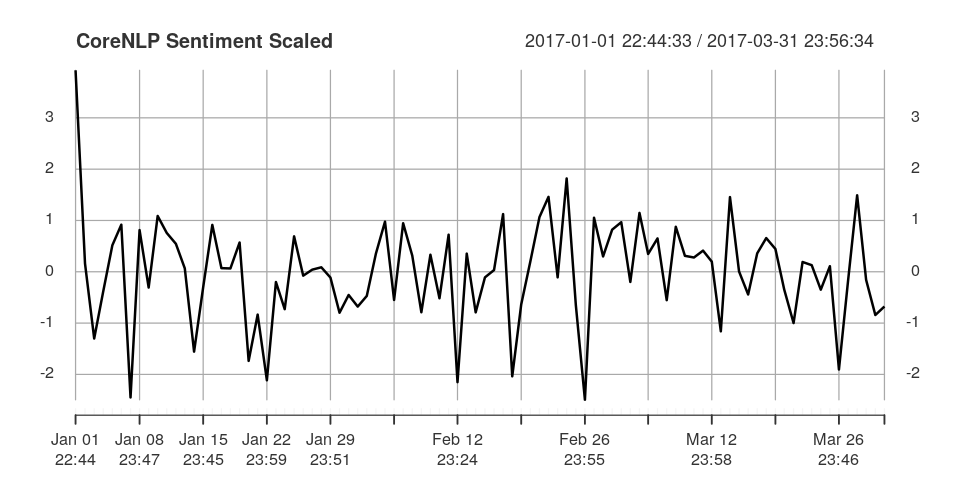

In [27]:
# Aggregate, standardize, and plot daily values...
plot(scale(apply.daily(ts, mean, na.rm=T)), main="CoreNLP Sentiment Scaled")

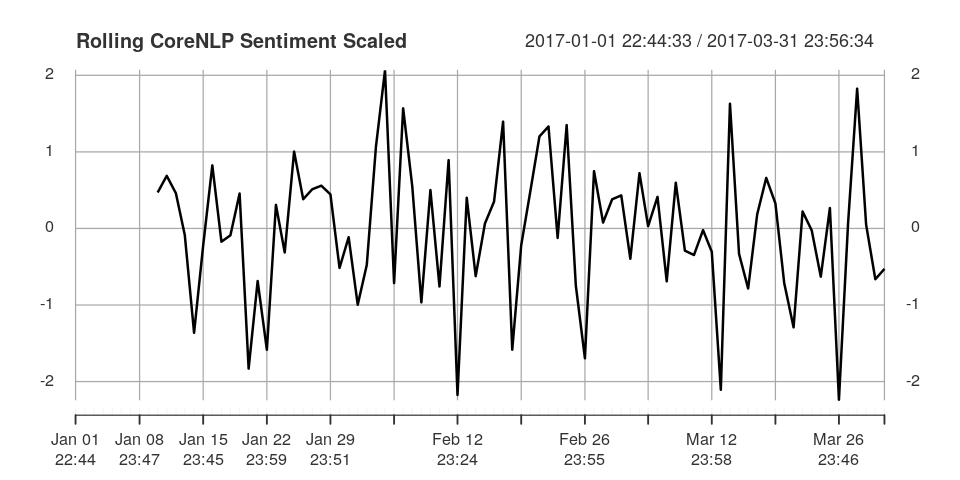

In [26]:
# Or to be time-sensitive, make sure you're not looking ahead...
plot(rollapply(apply.daily(ts, mean, na.rm=T), width=10, FUN=scale)[,10], main="Rolling CoreNLP Sentiment Scaled")

Not super informative.  But do you notice anything about day of week effects?  How would you find out?

## Fasttext

Let's look at fasttext, an embedding and training library by Facebook:

https://cran.r-project.org/web/packages/fastTextR/fastTextR.pdf
https://www.rdocumentation.org/packages/fastTextR/versions/1.0

Here are the papers.

First, let's notice that fasttext wants a peculiar input format:

```
__label__<X> <Text>
```

You use \__double\__ underscores to demonstrate the next term is a label.  Then the next field is the text.  There are additional normalization rules around the text encoding, but the normalize() function applies them.

Our project, rather than assuming the words of the English language have a syntactic and immutable meaning we can sum to arrive at a dictionary-based evaluation of the strength of an utterance, we are going to create a model in which the text of the answer we see form our X, and they are labelled by the score of the answer, Y.  That is, we create a supervised model where a string of text gets evaluated as belonging to the class = the number of upvotes an answer gets.

We're no longer modeling "sentiment" so much as "upvotesiness."  This reflects a different model of the world, but one more likely to be interesting.

An important caveat in this design is that we are not actually taking advantage of the ordered nature of our response variable---the categories are determined independently.  This seems to leave a lot of information on the table, but is what is used in other trainings, such as the Amazon data, and the Yelp star data.

Let's begin


In [119]:
# First install the package

# install.packages(c("fastTextR","textclean"), dep=T)
require("fastTextR")
require("textclean")

# We'll train with the January 2017 corpus.
df <- read.csv("data/nlp/sentiment-2017-01.csv", stringsAsFactors=FALSE)
dim(df)      # very small sample...
print(colnames(df)) # to see which we're keeping

# head(scale10(df$AnswerScore))

[1] 3727   20

 [1] "X.1"                "X"                  "ViewCount"         
 [4] "AskerId"            "AskerReputation"    "QuestionAsker"     
 [7] "DateAsked"          "PostId"             "Title"             
[10] "AnswerCount"        "QuestionScore"      "TagName"           
[13] "AnswererId"         "AnswererReputation" "Answerer"          
[16] "DateAnswered"       "AnswerScore"        "answertype"        
[19] "Body"               "sentiment"         


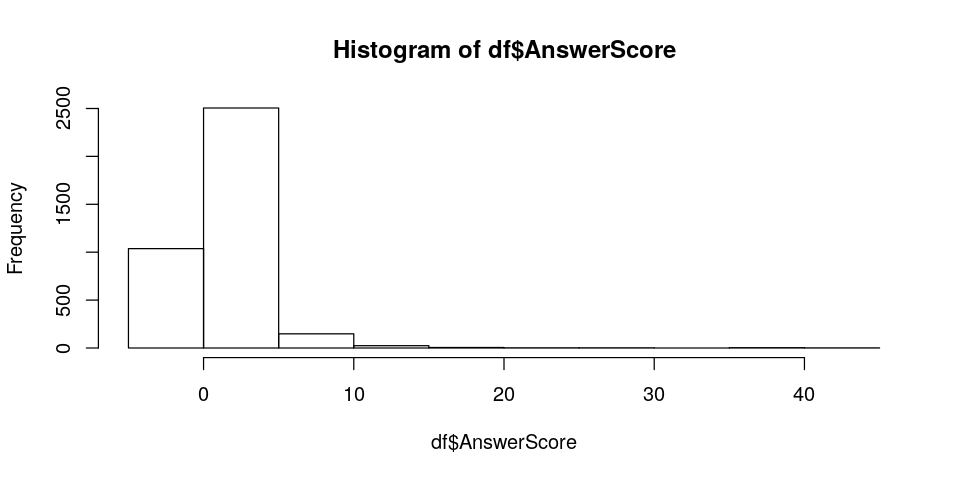

In [120]:
# Let's look at the distribution of scores
hist(df$AnswerScore)

As you can see, most items get between 0 and 10 stars.  Some get many many more.  Let's actually censor all data between 0 and 10, rounding harshly down to 10 when it gets higher.

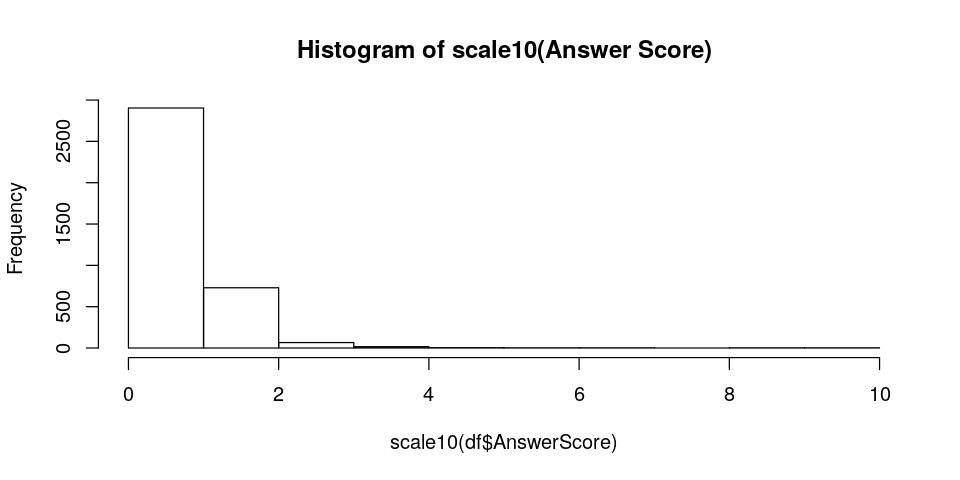

In [121]:
# Define a function to make all scores between 0 and 10
# This doesn't scale our categories, so it isn't the best.  
# We have a major class imbalance since most are 0 or 1 upvotes.
scale10 <- function(x){round(10*(x-min(x))/(max(x)-min(x)))}

hist(scale10(df$AnswerScore), main="Histogram of scale10(Answer Score)")

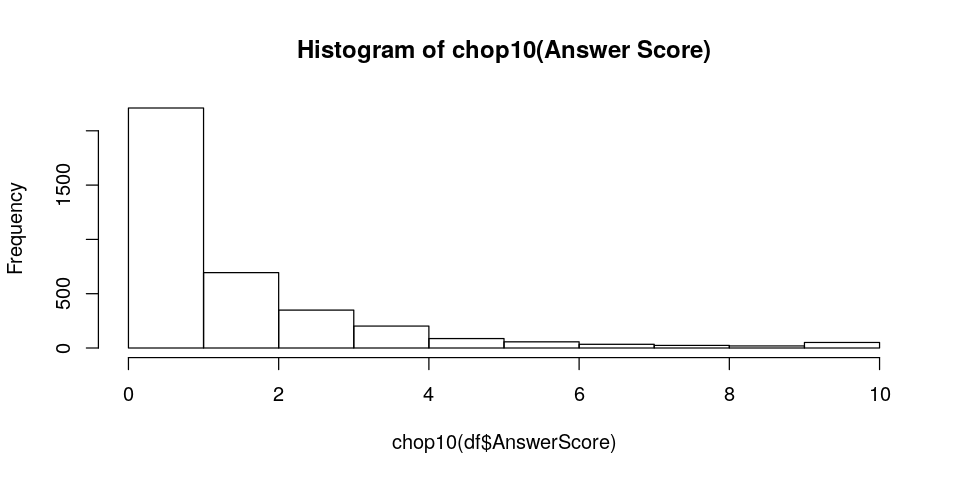

In [122]:
# Define a second that just truncates values > 10 to 10.
chop10 <- function(x) ifelse(x <= 0, 0, ifelse(x > 10, 10, x))

hist(chop10(df$AnswerScore), main="Histogram of chop10(Answer Score)")

In [123]:
# Define a function to turn our df above into a facebook formatted entry
fformat <- function(d) {
  tmp <- d[,c(17,19)] # AnswerScore, Body
  # lab <- scale10(tmp$AnswerScore)
  lab <- chop10(tmp$AnswerScore)
  tmp$lab <- paste0("__label__",lab)
  tmp$text <- cleaner(tmp$Body)
  tmp$AnswerScore <- NULL
  tmp$Body <- NULL
  fb <- tmp
  fb$vec <- paste(fb$lab, fb$text, sep=",")
  corpus <- normalize(fb$vec)
  return(list(lab, corpus))
}

r <- fformat(df)
lab <- r[[1]]
train <- r[[2]]

#print(head(r))

# head(test)
head(lab)
head(train)

[1] 3 7 0 1 1 4

[1] "__label__3 , You use same output two times in two tabPanel . Thats why it didnt show the . Use this-"                                                                                                                                                                                                                                                                                                                                                                                                                                                  
[2] "__label__7 , I , uh , \" just happened to have \" a copy of this font and did the dance and got your error . But , upon further inspection it seems the PDF device wants this name . While R has a host of awesomeness , the way it deals with fonts is about as nuanced and friendly and usable as a lizard crow ( #atla ) . UPDATE Complete example ( without the broken creation code and referencing vs and actually ing vs or after modifying the ggplot gtable That ^^ part makes the following PDF ( exported from Preview "                    
[3] "__label__0 , Your R interpreter is attempting to run Ghostscript from \" C \\program files\\gs\\gs9 . 09\\bin \" , whereas your Windows command line is executing Ghostscript 9 . 18 . Assuming that you installed a newer version of Ghostscript ( using the installer ) this means that Ghostscript will be installed in \" C \\program files\\gs\\gs9 . 18\\bin \" . You should check to see if you have Ghostscript 9 . 09 installed and . if not , then you will need to update your R configuration to use the correct directory for GS 9 . 18 ."
[4] "__label__1 , Here ' s one approach "                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
[5] "__label__1 , In addition to the answers provided in the link here is a / solution "                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
[6] "__label__4 , What you can do is substract the first year from the year of the date and multiply that by 12 and add that to the output of . This will add for the first year , for the second year and so on . Using gives In base R you could do it as follows ( as also suggested by @DavidArenburg ) "

In [124]:
# Write to disk
writeLines(train, con = "stacko.train")
# Train
model <- fasttext(input = "stacko.train", method = "supervised")

# For example...
# download.file("https://dl.fbaipublicfiles.com/fasttext/supervised-models/yelp_review_polarity.bin")
# model <- read.fasttext("yelp_review_polarity.bin")


In [126]:
df2 <- read.csv("data/nlp/sentiment-2017-02.csv", stringsAsFactors=FALSE)
r <- fformat(df2)
true_labels <- r[[1]]
test <- r[[2]]

head(true_labels)
head(test)

[1]  0  0 10  1  1  0

[1] "__label__0 , 1- base graphics draw immediately , you can ' t assign them to a variable 2- will place 4x2 plots per page"                                                                                                                                                                                                                                                                                                                                                    
[2] "__label__0 , Some operations in R don ' t look like function calls , but they are . For example , 3+4 can also be written as `+` ( 3 , 4 ) . In this case , since the partial function works by pre-filling in arguments , the \" substitute \" here works by substituting any variables found in the environment into \" . . . \" . quote ( ) works by capturing the action Seems like the fcall line is used to maintain what was originally placed into the partial call"
[3] "__label__10 , In order to have appendices after the references , you simply include a div with id= \" refs \" which tells pandoc where to include the references section . For example Credit https //twitter . com/tjmahr/status/763435602935095296"                                                                                                                                                                                                                       
[4] "__label__1 , You can get the list of all global variables using . Not an ideal solution ( because it retrieves a list of unnamed variables ) , but it should get you what you need . Reproducible example below"                                                                                                                                                                                                                                                            
[5] "__label__1 , This is no longer an issue , the documentation was updated too . See here https //github . com/rstudio/tensorflow/commit/4e1e11d6ba2fe7efe1a03356f96172dbf8db365e"                                                                                                                                                                                                                                                                                             
[6] "__label__0 , means that ODBC drivers are not installed on your mac . I would install iODBC and make sure the header files are present in the path"

In [127]:
test.pred <- predict(model, test, k = 1L, prob = TRUE)
confusion_matrix <- table(as.character(true_labels), gsub("\\D", "", test.pred$label))

head(test.pred$label)
head(test.pred$prob)

[1] "__label__1" "__label__1" "__label__1" "__label__1" "__label__1"
[6] "__label__1"

[1] 0.2636719 0.3046875 0.3046875 0.3066407 0.2832032 0.2968750

## So, how did we do?

In [130]:
# Do we always predict 1?
all(gsub("\\D", "", test.pred$label)=="1")

[1] TRUE

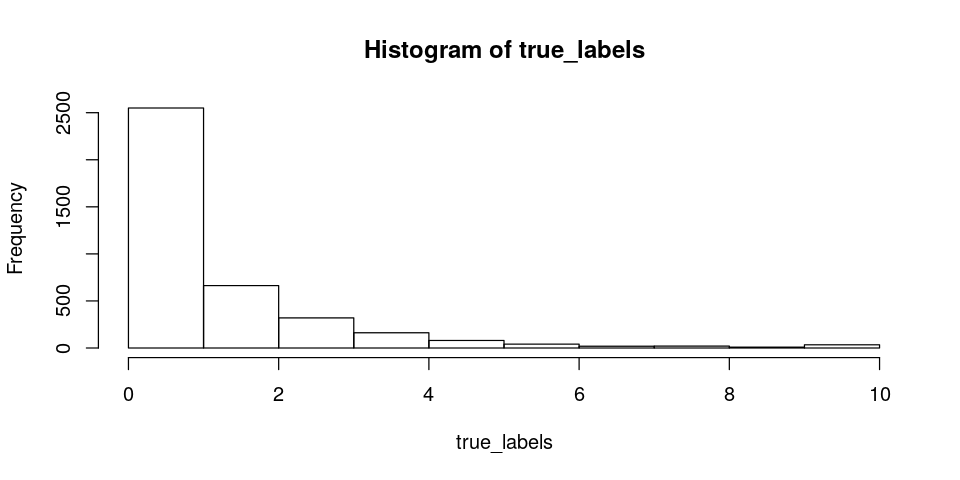

In [131]:
# but why?!
hist(true_labels)

## Analysis

Our fasttext analyzer very quickly decided it should assume everything is a category 1---that no matter what text you give it, you should always get 1 upvote.  

Why is that?  Let's consider two things:

1. First, there's a massive class inbalance. As you can see from the histogram of true labels, almost all of our actual samples, due to our transformation and also just the nature of the data, get scored as a 1.  
2. We had a _very_ small training sample, only 3727 total, which is nothing in machine learning.  Do you see any ways we can make that better? 

# WORKSHOP

- Let’s improve the sentiment prediction by finishing the fasttext training.
- What other data could we use to make an even better supervised model for “sentiment?”
- Try another framework---something with LSTMs?
- You have time series information.  Can you demonstrate people getting “nicer” or "more upvotey" over time?
- Recent research Stack Overflow released (Aug 14) doing NLP on this data: 	
  https://stackoverflow.blog/2019/08/14/crokage-a-new-way-to-search-stack-overflow/ 
- For all the marbles, can you make a generative model for answers based on Stack Overflow questions?